In [ ]:
!pip install tensorflow

# Import libraries

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and prepare data

In [2]:
lines = open('./words.txt', 'r').readlines()
labels = []
excludedImages = []
for line in lines:
    splittedLine = line.split(' ')
    if splittedLine[1] == 'err':
        excludedImages.append(splittedLine[0] + '.png')
    else:
        labels.append(splittedLine[-1].rstrip('\n'))
train_x = []
for folder1 in tqdm(os.listdir('./words')):
    for folder2 in os.listdir(f'./words/{folder1}'):
        for image in os.listdir(f'./words/{folder1}/{folder2}'):
            if(image in excludedImages):
                continue
            tmpImg = cv2.imread(f'./words/{folder1}/{folder2}/{image}', cv2.IMREAD_GRAYSCALE)
            tmpImg = cv2.resize(tmpImg, (256, 64))
            tmpImg = cv2.rotate(tmpImg, cv2.ROTATE_90_CLOCKWISE)
            tmpImg = tmpImg/255
            train_x.append(tmpImg)

train_x = np.array(train_x).reshape(-1, 256,64,1)

alphabet = ""
max_label = 0
for label in labels:
    if len(label) > max_label:
        max_label = len(label)
    for symbol in label:
        if symbol not in alphabet:
            alphabet += symbol
#ctc
train_y = np.ones([len(labels), max_label]) * len(alphabet)
for i, label in enumerate(labels):
    for j, symbol in enumerate(label):
        train_y[i][j] = alphabet.find(symbol)

validation_len = int(len(train_x)*0.1)

validation_x = train_x[:validation_len]
train_x = train_x[validation_len:]
validation_y = train_y[:validation_len]
train_y = train_y[validation_len:]

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:33<00:00,  1.13it/s]


# Create model

In [3]:
model = Sequential()
model.add(Conv2D(32, (5,5), padding= 'same', activation = 'relu', kernel_initializer='he_normal', input_shape=(256, 64, 1)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding= 'same', activation = 'relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding= 'same', activation = 'relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), padding= 'same', activation = 'relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D((1,2)))


model.add(Reshape((64,512)))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
          
model.add(Dense(len(alphabet) + 1, activation='softmax'))

@keras.utils.register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

model.compile(optimizer = Adam(learning_rate=0.001), loss = CTCLoss)
history = model.fit(train_x, train_y, validation_data=(validation_x, validation_y), epochs=20, batch_size=64, verbose=1)
model.save('./model3.keras')

Epoch 1/20
689/689 [==============================] - 684s 984ms/step - loss: 13.1865 - val_loss: 13.1232
Epoch 2/20
689/689 [==============================] - 666s 966ms/step - loss: 7.2159 - val_loss: 5.2008
Epoch 3/20
689/689 [==============================] - 660s 958ms/step - loss: 4.1449 - val_loss: 5.3521
Epoch 4/20
689/689 [==============================] - 665s 965ms/step - loss: 3.2171 - val_loss: 3.6075
Epoch 5/20
689/689 [==============================] - 669s 971ms/step - loss: 2.7250 - val_loss: 3.5107
Epoch 6/20
689/689 [==============================] - 699s 1s/step - loss: 2.3636 - val_loss: 3.7050
Epoch 7/20
689/689 [==============================] - 668s 969ms/step - loss: 2.0972 - val_loss: 4.3806
Epoch 8/20
689/689 [==============================] - 663s 963ms/step - loss: 1.8647 - val_loss: 3.2856
Epoch 9/20
689/689 [==============================] - 660s 958ms/step - loss: 1.6894 - val_loss: 2.8229
Epoch 10/20
689/689 [==============================] - 664s 964ms

# Test

In [4]:
def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == -1:
            break
        else:
            text += alphabet[ch]
    return text

1/1 [==============================] - 0s 22ms/step


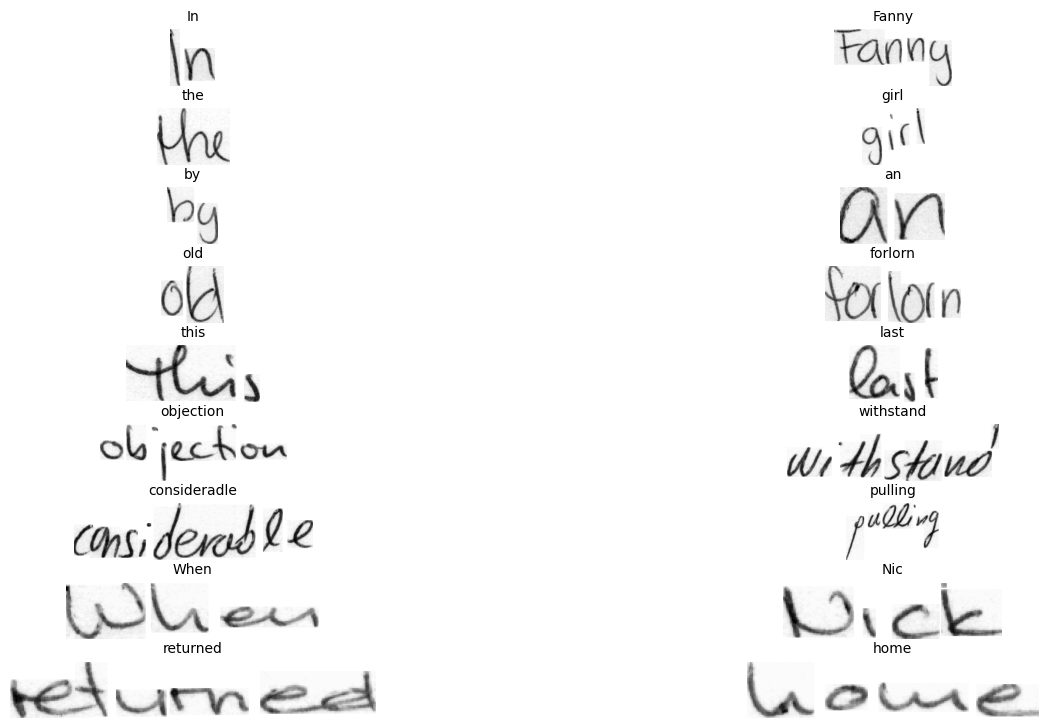

In [5]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)
plotIterator = 0
for file in os.listdir('./test'):
    plt.subplot(len(os.listdir('./test')), 2, plotIterator+1)
    image = cv2.imread(f'./test/{file}', cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = cv2.resize(image, (256, 64))
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = image/255
    prediction = model.predict(image.reshape(1,256,64,1))
    decoded = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])
    plt.title(num_to_label(decoded[0], alphabet), fontsize=10)
    plotIterator+=1
    plt.axis('off')